In [1]:
import numpy as np
from datetime import datetime

csv_file = "Stage.Working@08MH028.20110101_corrected.csv"
skip_rows = 15  # header line

# Read all lines after header
with open(csv_file, 'r') as f:
    lines = f.readlines()[skip_rows:]

# Keep only lines with at least 3 columns
data_lines = [line.strip().split(',') for line in lines if len(line.strip().split(',')) >= 3]

# Convert timestamps and stage values
stages = np.array([
    [datetime.strptime(row[0], "%Y-%m-%dT%H:%M:%SZ"), float(row[2])]
    for row in data_lines
])

# Filter for 2023-01-01 to 2024-12-31
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 12, 31, 23, 59, 59)

mask = (stages[:, 0] >= start_date) & (stages[:, 0] <= end_date)
stages = np.array(stages)[mask]

print("Loaded", len(stages), "rows")
print(stages.shape)


Loaded 209661 rows


In [20]:
stages[0][0], stages[0][1]

(datetime.datetime(2023, 1, 1, 0, 0), 3.01190610530716)

In [21]:
timestamps = np.load("processed-data/timestamps.npz", allow_pickle=True)['timestamps']
timestamps.shape


(17535,)

In [43]:
import numpy as np

# Convert datetime objects to UNIX timestamps (seconds)
timestamps_unix = np.array([t.timestamp() for t in timestamps])
stage_times_unix = np.array([t.timestamp() for t in stages[:, 0]])

idx = np.searchsorted(stage_times_unix, timestamps_unix)
idx = np.clip(idx, 1, len(stage_times_unix)-1)

# Compare distances to previous entry — pick whichever is closer
prev = stage_times_unix[idx-1]
next = stage_times_unix[idx]
idx_closest = np.where(
    np.abs(timestamps_unix - prev) < np.abs(timestamps_unix - next),
    idx-1, idx
)

# Extract corresponding values
stages_aligned = stages[idx_closest, 1].astype(float)

print(stages_aligned.shape)
print(stages_aligned[:10])


(17535,)
[3.01190611 2.4149143  1.88892249 1.53093069 1.41493888 1.58394707
 1.92995527 2.38696346 2.84697165 3.19897985]


In [63]:
import os

np.savez_compressed(os.path.join("./processed-data/", 'river_heights.npz'), river_heights=stages_aligned)

In [44]:
stages_aligned[0]

np.float64(3.01190610530716)

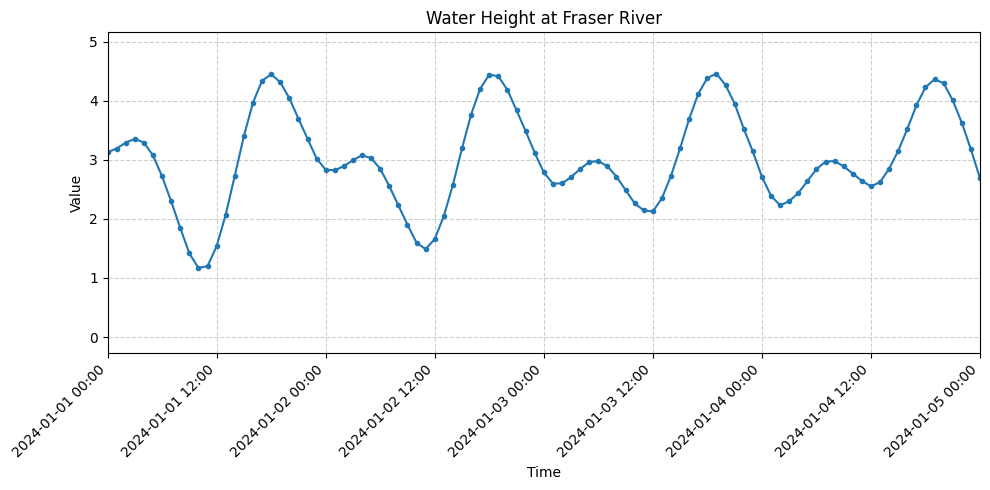

In [61]:
from plot_utils import plot_timeseries

plot_timeseries(timestamps, stages_aligned,
                start=datetime(2024, 1, 1),
                end=datetime(2024, 1, 5),
                title="Water Height at Fraser River",)


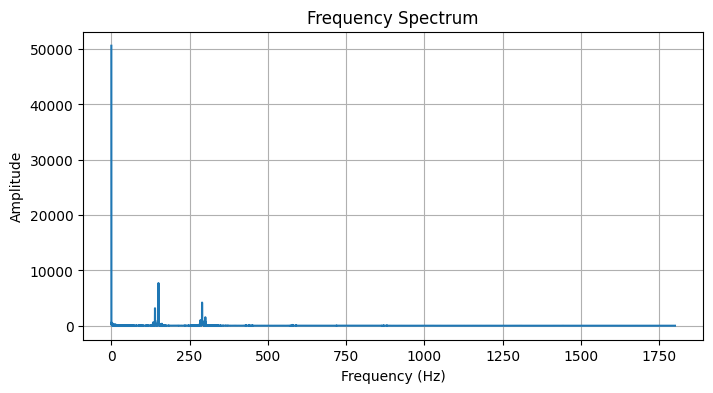

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Perform FFT
fft_values = np.fft.fft(stages_aligned)
freqs = np.fft.fftfreq(len(stages_aligned), 1/(60*60))

# Keep only positive frequencies
mask = freqs >= 0
fft_values = fft_values[mask]
freqs = freqs[mask]

# Plot frequency spectrum
plt.figure(figsize=(8,4))
plt.plot(freqs, np.abs(fft_values))
plt.title("Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()
